In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.vq import *
from sklearn.svm import LinearSVC
from sklearn.externals import joblib
import math
import random
from sklearn.metrics import roc_curve, auc

In [2]:
def objectDetection(videofile):
    cap = cv2.VideoCapture(videofile)
    print("The video has  {0} frames".format(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
#     print("The video is playing at {} frames per second.".format(cap.get(cv2.CV_CAP_PROP_FPS)))
    # Trained XML classifiers describes some features of some object we want to detect
    car_cascade = cv2.CascadeClassifier('cars.xml')

    while(True):
        # Capture frame-by-frame
        ret, frame = cap.read()

        if ret == False:
            break

        # Our operations on the frame come here
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detects cars of different sizes in the input image
        cars = car_cascade.detectMultiScale(gray, 1.1, 1)

        # To draw a rectangle in each cars
        for (x,y,w,h) in cars:
            cv2.rectangle(gray,(x,y),(x+w,y+h),(0,0,255),2)

        # Display the resulting frame
        cv2.imshow('frame',gray)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # When everything done, release the capture
    cap.release()
    cv2.destroyAllWindows()

In [3]:
def tracking(videofile):
    cap = cv2.VideoCapture(videofile)
    print('Tracking features for: {}'.format(videofile))
    ret, frame1 = cap.read()
    frame1 = cv2.resize(frame1, (400, 400)) 
    prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
    hsv = np.zeros_like(frame1)
    hsv[...,1] = 255
    features = []

    while(1):
        ret, frame2 = cap.read()

        if(ret == False):
            break

        frame2 = cv2.resize(frame2, (400, 400)) 
        next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
#         print(np.array(next).shape)

        flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        hsv[...,0] = ang*180/np.pi/2
        hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
        rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
        
        hof, binedges = np.histogram(ang,bins=450,range=(0,360))

        features.append(hof[:8])

        cv2.imshow('frame2',rgb)
         # Display the resulting frame
        cv2.imshow('frame3',next)
        k = cv2.waitKey(30) & 0xff
        if k == 27:
            break
       
        prvs = next   
    
#     print('Length of features before sampling {}'.format(len(features)))
#     print(len(features))
    samplesize = 250
    if(len(features) < samplesize):
        samplesize = len(features)
        
    features = random.sample(features, samplesize)
#     print(features)
#     print('Length of features after sampling {}'.format(len(features)))
    cap.release()
    cv2.destroyAllWindows()
    return features

In [4]:
def generateCodebook(features, k):
    print('Generating Code book for all features')
    X = np.array(features[0][1])
    for path, feature in features[1:]:
        X = np.vstack((X, feature))
        
    print(len(X))
    print(X[X == float('nan')])
    codebook, variance = kmeans(X.astype(float), k, 1) 
    return codebook

In [5]:
def generateBOW(features, codebook):
    print('Create Bag of Visual Words features')
    bow = np.zeros((len(features), len(codebook)), "float32")
    i = 0
    for path, feature in features[0:]:
        words, d = vq(feature,codebook)
        for w in words:
            bow[i][w] += 1
        i = i + 1
    
    return bow

In [6]:
def extractFeatures():
    allfeatures = []
    f = range(1,11)
    k = 500
    classoutput = []
    i = 1;
    while(i < 3):
        for fn in f:
            if(i == 1):
                videofile = 'normal/{}.mov'.format(fn)
                classoutput.append(1)
            if(i == 2):
                videofile = 'abnormal/{}.mov'.format(fn)
                classoutput.append(-1)
                
        #     objectDetection(videofile)
            feature = tracking(videofile)
            allfeatures.append((videofile,feature))
        i = i + 1;

    codebook = generateCodebook(allfeatures, k)
    bagOfWordsFeatures = generateBOW(allfeatures, codebook)
        
#     print(bagOfWordsFeatures)
    return bagOfWordsFeatures,classoutput,codebook
    

In [7]:
def trainVideo(features, classes):
    print('Train the features')
    clf = LinearSVC()
    clf.fit(features, classes)
    return clf

In [8]:
def testVideo(model, videofile, codebook):
    print('Test the features')
    feature = tracking(videofile)
    bagOfWordsFeatures = generateBOW([(videofile,feature)], codebook)
    output = model.predict(bagOfWordsFeatures)
    if(output == 1):
        print('The video has normal flow of traffic')
    if(output == -1):
        print('The video does not have normal flow of traffic')
    

In [9]:
def main():
        features,classoutput, codebook = extractFeatures()
        joblib.dump(codebook, 'codebook.sav')
        model = trainVideo(features, classoutput)
        joblib.dump(model, 'model.sav')
        

In [147]:
main()

Tracking features for: normal/1.mov
Tracking features for: normal/2.mov
Tracking features for: normal/3.mov
Tracking features for: normal/4.mov
Tracking features for: normal/5.mov
Tracking features for: normal/6.mov
Tracking features for: normal/7.mov
Tracking features for: normal/8.mov
Tracking features for: normal/9.mov
Tracking features for: normal/10.mov
Tracking features for: abnormal/1.mov
Tracking features for: abnormal/2.mov
Tracking features for: abnormal/3.mov
Tracking features for: abnormal/4.mov
Tracking features for: abnormal/5.mov
Tracking features for: abnormal/6.mov
Tracking features for: abnormal/7.mov
Tracking features for: abnormal/8.mov
Tracking features for: abnormal/9.mov
Tracking features for: abnormal/10.mov
Generating Code book for all features
4900
[]
Create Bag of Visual Words features
Train the features


In [10]:
def testFromSavedModel(videofile):
    model = joblib.load('model.sav')
    codebook = joblib.load('codebook.sav')
    testVideo(model,videofile, codebook)
    

In [44]:
def testMetrics():
    model = joblib.load('model.sav')
    codebook = joblib.load('codebook.sav')
    f = range(1,11)
    allfeatures = []
    actualoutput = []
    
    for fn in f:
        videofile = 'test/{}.mov'.format(fn)
        feature = tracking(videofile)
        allfeatures.append((videofile,feature))
        actualoutput.append(1)
        
    f = range(21,30)
    for fn in f:
        videofile = 'test/{}.mov'.format(fn)
        feature = tracking(videofile)
        allfeatures.append((videofile,feature))
        actualoutput.append(-1)
        
    bagOfWordsFeatures = generateBOW(allfeatures, codebook)
    predictedoutput = model.predict(bagOfWordsFeatures)
    return (actualoutput, predictedoutput)
    

In [39]:
def plotROC(actual, predictions):
    fpr, tpr, threshold = roc_curve(actual,predictions)
    roc_auc = auc(fpr,tpr)
    plt.title('ROC')
    plt.plot(fpr,tpr,'b--', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [37]:
testFromSavedModel('test/7.mov')

Test the features
Tracking features for: test/7.mov
Create Bag of Visual Words features
The video does not have normal flow of traffic


In [14]:
testFromSavedModel('test/24.mov')

Test the features
Tracking features for: test/24.mov
Create Bag of Visual Words features
The video does not have normal flow of traffic


In [175]:
ftrs = tracking('test/23.mov')
print(np.array(ftrs).shape)

Tracking features for: test/23.mov
(250, 8)


In [20]:
objectDetection('normal/2.mov')

The video has  251.0 frames


In [45]:
actual, predictions = testMetrics()

Tracking features for: test/1.mov
Tracking features for: test/2.mov
Tracking features for: test/3.mov
Tracking features for: test/4.mov
Tracking features for: test/5.mov
Tracking features for: test/6.mov
Tracking features for: test/7.mov
Tracking features for: test/8.mov
Tracking features for: test/9.mov
Tracking features for: test/10.mov
Tracking features for: test/21.mov
Tracking features for: test/22.mov
Tracking features for: test/23.mov
Tracking features for: test/24.mov
Tracking features for: test/25.mov
Tracking features for: test/26.mov
Tracking features for: test/27.mov
Tracking features for: test/28.mov
Tracking features for: test/29.mov
Create Bag of Visual Words features


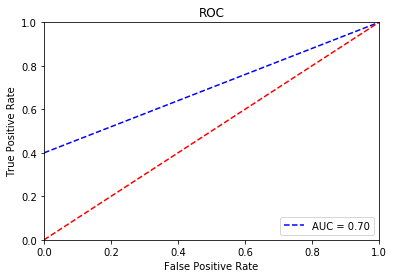

In [46]:
plotROC(actual, predictions)